# TemplateFlow

A resource for handling neuroimaging templates and atlases.

Components:

* The *TemplateFlow Archive*
* The *Python Client*
* The *TemplateFlow Registration Framework*

Check [www.templateflow.org](https://www.templateflow.org)

# The Python Client
Provides an easy interface to access the *Archive* by humans and programs.

## Easy to install

In [1]:
!pip install templateflow --user

# Easy to use
The `api` submodule contains all the utilities

In [2]:
from templateflow import api

For instance, we can query the *Archive* to learn the list of templates currently available:

In [3]:
api.templates()

['MNI152Lin',
 'MNI152NLin2009cAsym',
 'MNI152NLin2009cSym',
 'MNI152NLin6Asym',
 'MNI152NLin6Sym',
 'MNIInfant',
 'MNIPediatricAsym',
 'NKI',
 'OASIS30ANTs',
 'PNC',
 'WHS',
 'fsLR',
 'fsaverage']

Let's say we want to use the CerebrA parcellation recently published by the MNI group. The parcellation is defined on their `"MNI152NLin2009cSym"` template:

In [4]:
api.get("MNI152NLin2009cSym", atlas="CerebrA")

PosixPath('/home/jovyan/.cache/templateflow/tpl-MNI152NLin2009cSym/tpl-MNI152NLin2009cSym_res-1_atlas-CerebrA_dseg.nii.gz')

## Lazy-loading
The first time we request a file, it gets downloaded to the `$TEMPLATEFLOW_HOME` folder, which by default points to `$HOME/.cache/templateflow`. The second time we run the same query, it's already fetched and available:

In [5]:
api.get("MNI152NLin2009cSym", atlas="CerebrA")

PosixPath('/home/jovyan/.cache/templateflow/tpl-MNI152NLin2009cSym/tpl-MNI152NLin2009cSym_res-1_atlas-CerebrA_dseg.nii.gz')

## PyBIDS-like interface
The client just defines a new configuration object for PyBIDS, which is actually used in indexing and querying the Archive. For example, let's say we will need the anatomical reference of the CerebrA parcellation:

In [6]:
api.get("MNI152NLin2009cSym", suffix="T1w")

PosixPath('/home/jovyan/.cache/templateflow/tpl-MNI152NLin2009cSym/tpl-MNI152NLin2009cSym_res-1_T1w.nii.gz')

# The *TemplateFlow Archive*

The *Archive* is a replicated repository (stored on the OSF and a public S3 bucket) managed and version-controlled with DataLad.

We are building a contribution workflow, so that users can easily upload their templates.

<img src="https://github.com/nipreps/nipreps.github.io/raw/mkdocs/docs/assets/torw2020/assets/templateflow-datatypes.png" style="width: 100%" />

Currently available templates can be browsed with the [online browser](https://www.templateflow.org/archive/#browse-the-archive)

<img src="https://github.com/nipreps/nipreps.github.io/raw/mkdocs/docs/assets/torw2020/assets/templateflow-archive.png" style="width: 50%" />

Accessing the Archive can be done with the Python client (recommended) or directly with Datalad (discouraged):

In [7]:
!datalad install -r ///templateflow

[INFO   ] Installing Dataset(/home/jovyan/curriculum/we-nipreps-esteban/templateflow) to get /home/jovyan/curriculum/we-nipreps-esteban/templateflow recursively 


In [8]:
!ls templateflow/

dataset_description.json  tpl-MNI152NLin2009cSym  tpl-NKI
tpl-fsaverage		  tpl-MNI152NLin6Asym	  tpl-OASIS30ANTs
tpl-fsLR		  tpl-MNI152NLin6Sym	  tpl-PNC
tpl-MNI152Lin		  tpl-MNIInfant		  tpl-WHS
tpl-MNI152NLin2009cAsym   tpl-MNIPediatricAsym


# Use-case: extracting time-series from preprocessed data
The following use-case shows how to use the Finger/Foot/Lips motor task in DS000114, after preprocessing with fMRIPrep.

The full dataset after preprocessing has been uploaded to [G-Node](https://gin.g-node.org/oesteban/ds000114/). We will extract the time-series for subject `05`, session `test`, and task `fingerfootlips`.

Therefore, we will work on `sub-05_ses-test_task-fingerfootlips_space-MNI152NLin6Asym_res-02_desc-preproc_bold.nii.gz`, for which there's a symlink under `~/data/nipreps/templateflow/`.

In [9]:
from os import path as op
data_file = op.expanduser(
    "~/data/nipreps/templateflow/"
    "sub-05_ses-test_task-fingerfootlips_space-MNI152NLin6Asym_res-02_desc-preproc_bold.nii.gz"
)
regressors_file = op.expanduser(
    "~/data/nipreps/templateflow/"
    "sub-05_ses-test_task-fingerfootlips_desc-confounds_regressors.tsv"
)

We will use the Schaefer parcellation with 7 networks and 100 ROIs, at the lower resolution (``res-02``) of the reference template (which is FSL's MNI, or `MNI152NLin6Asym` for TemplateFlow).

In [10]:
atlas_filename = str(
    api.get("MNI152NLin6Asym", atlas="Schaefer2018", resolution=2, desc="100Parcels7Networks")
)

*Nilearn* provides a very convenient way of visualizing this particular parcellation:

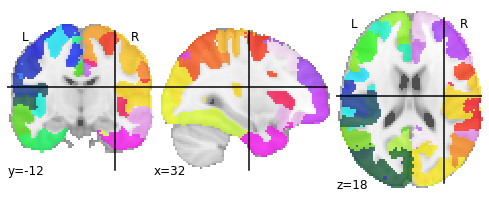

In [11]:
from nilearn import plotting
plotting.plot_roi(atlas_filename)

Let's examine how the parcellation looks on our data:

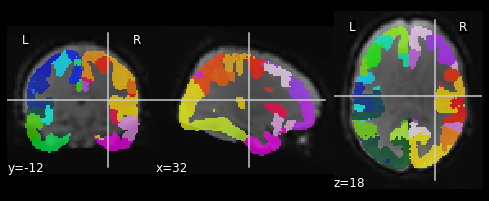

In [12]:
import nibabel as nb
data_nii = nb.load(data_file)
data_avg = data_nii.get_fdata().mean(axis=3)
avg_nii = nb.Nifti1Image(data_avg, data_nii.affine)
plotting.plot_roi(atlas_filename, bg_img=avg_nii)

Finally, we use `NiftiLabelsMasker` from nilearn to extract the time-series:

In [14]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)
time_series = masker.fit_transform(data_file)
time_series.shape

(184, 100)

# Thanks!

More at www.templateflow.org!